In [3]:
print("Start")

Start


In [4]:
%matplotlib inline

import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from go_detection.common.asset_io import AssetIO
from go_detection.dataloader import create_datasets, create_datasets_split, GoDynamicDataset
from go_detection.config import DataCfg, SimCfg
from go_detection.dataloader import (
    DataPoint,
    DataPoints,
    DistSampler,
    NonReplacementSampler,
    UniformSampler,
    create_datasets,
)
from go_detection.dataloader_viz import visualize_accuracy_over_num_pieces
from go_detection.common.matplotlib_utils import draw_histogram, draw_pmf
from collections import defaultdict




Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


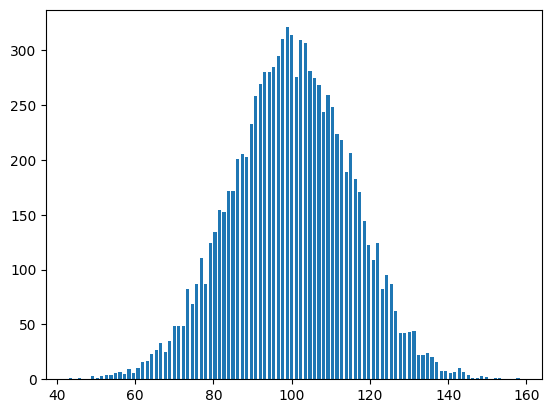

In [5]:
mu, sigma = 100, 15
x = mu + sigma * np.random.randn(10000)

hist, bins = np.histogram(x, bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [6]:
data_cfg = DataCfg(
    base_path="/home/rmenon/Desktop/dev/datasets/go_board/dataset",
    train_split_percent="0.9",
    randomize_train_split=False,
    use_dynamic_dataset=True,
    train_batch_size=1,
    test_batch_size=1,
)
train, test = create_datasets_split(data_cfg)

train_dataset, test_dataset = GoDynamicDataset(train, data_cfg.base_path), GoDynamicDataset(test, data_cfg.base_path)
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")

Train dataset: 1903, Test dataset: 249


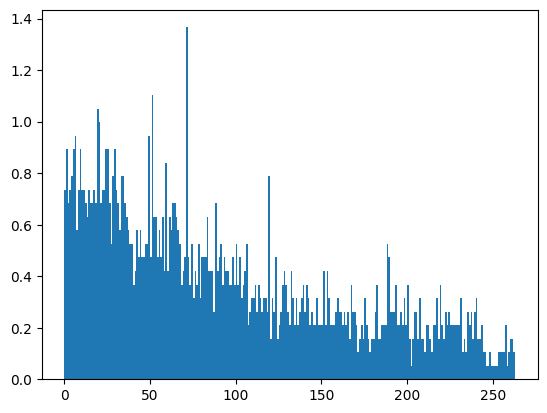

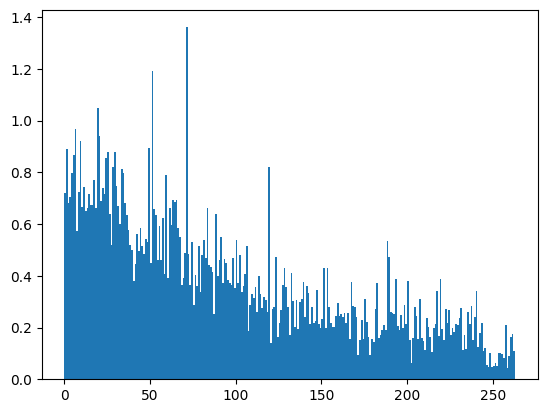

In [8]:
def draw_hist_with_sampler(sampler, fig_path, num_samples):
        temp = []
        for _ in range(num_samples):
            idx = next(sampler_iter)
            temp.append(train_dataset.num_pieces[idx].item())
        temp = np.array(temp)
        draw_histogram(
            temp,
            fig_path,
            bins=temp.max(),
        )

sampler_iter = iter(NonReplacementSampler(len(train_dataset), False))
draw_hist_with_sampler(
    sampler_iter, None, len(train_dataset),
)
sampler_iter = iter(UniformSampler(len(train_dataset), 1000))
draw_hist_with_sampler(
    sampler_iter, None, 10**5,
)

(1903,)


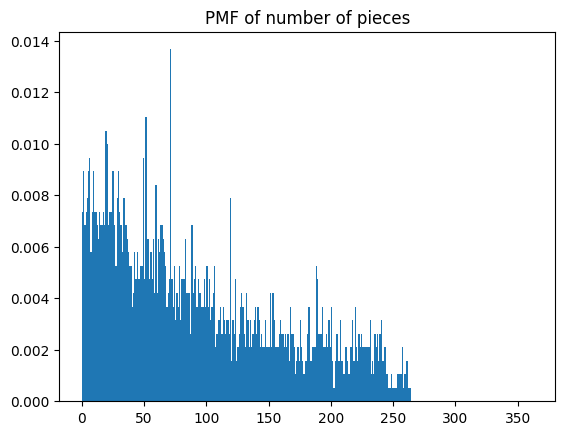

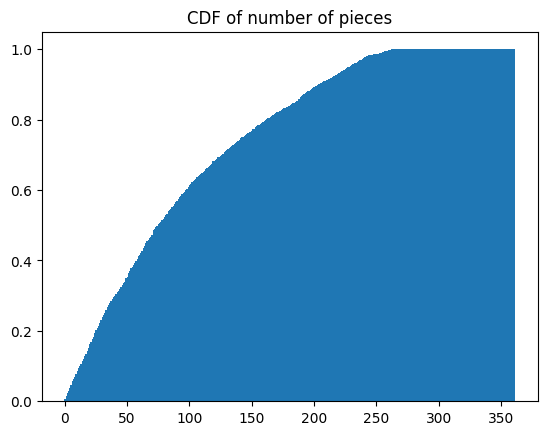

In [213]:
sampler_iter = iter(NonReplacementSampler(len(train_dataset), False))
data = []
for _ in range(len(train_dataset)):
    idx = next(sampler_iter)
    data.append(train_dataset.num_pieces[idx].item())
data = np.array(data)

print(data.shape)
total_possibilities = 19*19 + 1
hist, bins = np.histogram(data, bins=np.arange(0, total_possibilities+1))

pmf = hist / hist.sum()
cdf = np.cumsum(pmf)

fig, ax = plt.subplots()
ax.bar(np.arange(0, total_possibilities), pmf, align="edge", width=width)
ax.set_title("PMF of number of pieces")
plt.show()


fig, ax = plt.subplots()
ax.bar(np.arange(0, total_possibilities), cdf, align="center", width=width)
ax.set_title("CDF of number of pieces")
plt.show()

264
--
263
10000


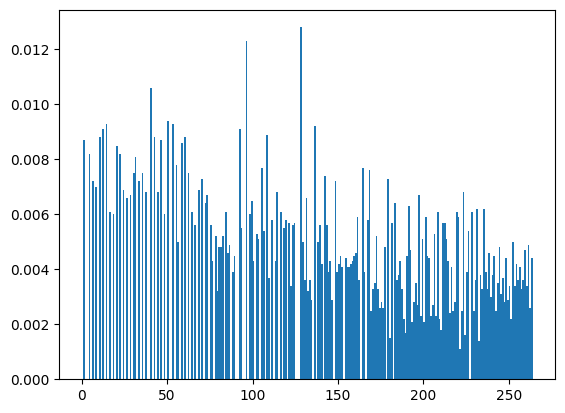

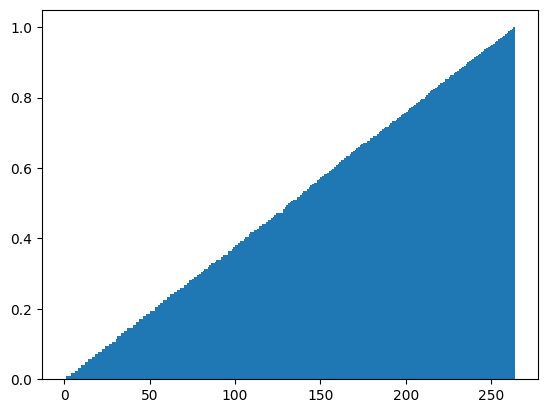

In [200]:
# Trying to use transform sampling 

total_possibilities = data.max() + 1 
print(total_possibilities)
# total_possibilities = 19 * 19 + 1
hist, bins = np.histogram(data, bins=np.arange(0, total_possibilities+1))

pmf = hist / hist.sum()
cdf = np.cumsum(pmf)

print("--")
sampler_iter = iter(UniformSampler(len(train_dataset), 10000))
# sampler_iter = iter(NonReplacementSampler(len(train_dataset)))
new_data = []
for _ in range(10 ** 4):
    idx = next(sampler_iter)
    num_pieces = train_dataset.num_pieces[idx].item()
    
    cdf_val = cdf[num_pieces] * total_possibilities
    # print(cdf_val)
    cdf_val = np.round(cdf_val)
    if cdf_val == total_possibilities:
        cdf_val = total_possibilities-1
    cdf_val = int(cdf_val)
    
    new_num_pieces = cdf_val
    new_data.append(new_num_pieces)
new_data = np.array(new_data)

print(new_data.max())
hist, bins = np.histogram(new_data, bins=np.arange(0, total_possibilities+1))

print(hist.sum())
new_pmf = hist / hist.sum()
new_cdf = np.cumsum(new_pmf)

fig, ax = plt.subplots()
ax.bar(bins[:-1], new_pmf, align="edge", width=1.0)
plt.show()

fig, ax = plt.subplots()
ax.bar(bins[:-1], new_cdf, align="edge", width=1.0)
plt.show()



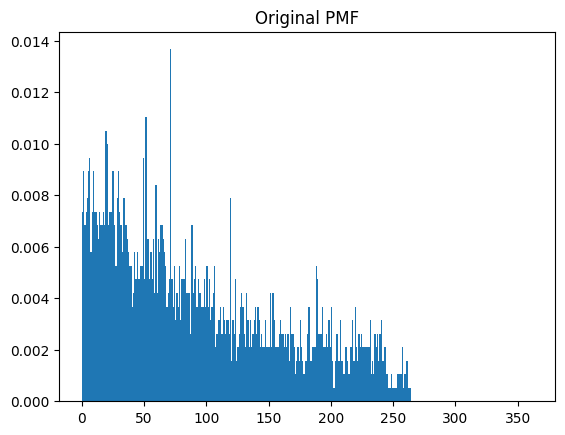

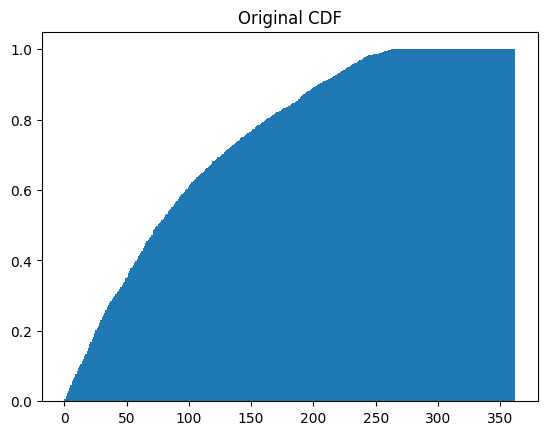

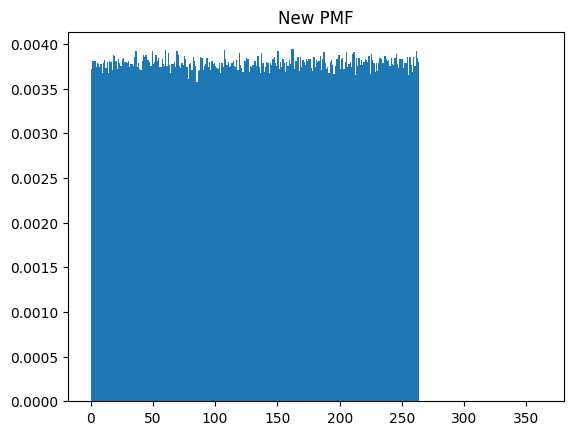

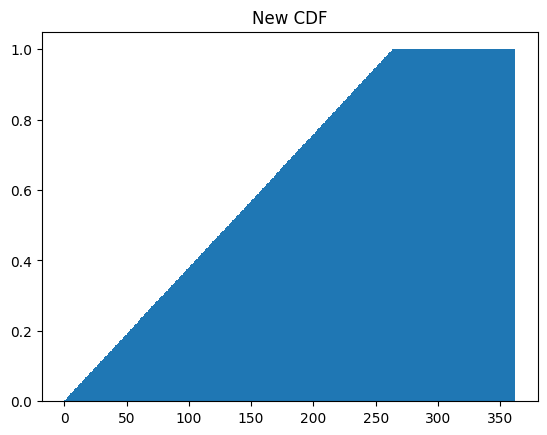

In [214]:
# Full example
total_possibilities = 19 * 19 + 1

sampler_iter = iter(NonReplacementSampler(len(train_dataset), False))
data = []
for _ in range(len(train_dataset)):
    idx = next(sampler_iter)
    data.append(train_dataset.num_pieces[idx].item())
data = np.array(data)
hist, bins = np.histogram(data, bins=np.arange(0, total_possibilities+1))

original_pmf = hist / hist.sum()
original_cdf = np.cumsum(original_pmf)

plt.bar(bins[:-1], original_pmf, align="edge", width=1.0)
plt.title("Original PMF")
plt.show()

plt.bar(bins[:-1], original_cdf, align="edge", width=1.0)
plt.title("Original CDF")
plt.show()

pmf = original_pmf.copy()
pmf[pmf == 0.0] = np.inf
weights = 1.0 / pmf

sampler_iter = iter(NonReplacementSampler(len(train_dataset), False))
full_weights = []
for _ in range(len(train_dataset)):
    idx = next(sampler_iter)
    full_weights.append(
        weights[train_dataset.num_pieces[idx].item()]
    )
full_weights = np.array(full_weights)
full_weights = full_weights / full_weights.sum()


sampler_iter = iter(DistSampler(full_weights, 10000))
new_data = []
for _ in range(1000 * 1000):
    idx = next(sampler_iter)
    new_data.append(train_dataset.num_pieces[idx].item())
new_data = np.array(new_data)

hist, bins = np.histogram(new_data, bins=np.arange(0, total_possibilities+1))

new_pmf = hist / hist.sum() 
new_cdf = np.cumsum(new_pmf)

plt.bar(bins[:-1], new_pmf, align="edge", width=1.0)
plt.title("New PMF")
plt.show()

plt.bar(bins[:-1], new_cdf, align="edge", width=1.0)
plt.title("New CDF")
plt.show()

